In [1]:
# pip install -U spacy
# pip install scispacy
# pip install "tensorflow_hub>=0.6.0"
# pip install "tensorflow>=2.0.0"

import numpy as np
import torch
import tensorflow
import pandas as pd
import os
import json
import time
import glob
import re
import sys
import collections
from itertools import chain
import random
import joblib
from bs4 import BeautifulSoup

from nltk import flatten

import scispacy
import spacy
import en_core_sci_lg
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
from spacy.symbols import ORTH
from spacy.util import minibatch, compounding

import tensorflow as tf
import tensorflow_hub as hub

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
tqdm_notebook.pandas()


/Users/zhiyulin/opt/anaconda3/envs/anly580/lib/python3.8/site-packages/spacy/util.py:717: UserWarning: [W094] Model 'en_core_sci_lg' (0.2.4) specifies an under-constrained spaCy version requirement: >=2.2.1. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.0.6,<3.1.0
  warnings.warn(warn_msg)
<ipython-input-1-7543ea62f53b>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook
/Users/zhiyulin/opt/anaconda3/envs/anly580/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
module_url = "https://tfhub.dev/google/nnlm-en-dim128/2"
embed = hub.KerasLayer(module_url)

In [5]:
embed

In [4]:
df = pd.read_csv('action_state_text.csv', index_col=0)
df

,action,state
0,hear argument morning case number brnovich ver...,mr chief justice may please court think key co...
1,mr carvin understand test articulate reduce an...,entirely mr chief justice reason involve diffe...
2,talk concern analysis would drive racial propo...,well mean neutral system must change order max...
3,really maximize participation equalize word co...,well example would eliminate valuable antifrau...
4,thank mr chief justice mr carvin understand ra...,well justice thomas think speak precisely term...
...,...,...
11515,let's put aside unwilling second allege employ...,think would look know publicly disclose financ...
11516,allege dispute pleading stage envision kind pr...,well mean think allege sufficient particularit...
11517,question subject matter jurisdiction article i...,exactly right honor that's actually happen dis...
11518,think that's right separate factual proceeding...,exactly that's actually happen plan overfunded...


In [6]:
action_list = embed(df['action'].tolist())
action_df = pd.DataFrame(action_list.numpy())
action_df.columns = ['embed_' + str(e) for e in range(action_df.shape[1])]
action_df

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_118,embed_119,embed_120,embed_121,embed_122,embed_123,embed_124,embed_125,embed_126,embed_127
0,0.158090,0.284454,-0.095435,-0.446835,-0.012970,-0.030793,0.124711,0.005525,-0.113778,0.198498,...,-0.231224,-0.124470,0.109001,-0.152654,-0.002325,0.071294,-0.028048,-0.011360,0.237537,-0.099187
1,0.348855,0.171468,0.171813,-0.505834,0.044602,-0.095183,0.309858,0.258406,0.052072,0.277860,...,-0.033372,-0.027734,0.159644,-0.181154,0.032207,0.148363,-0.234576,-0.248888,0.238060,0.029568
2,0.151827,0.256663,-0.046116,-0.513523,-0.201615,-0.341899,0.196127,0.002691,0.053761,0.238128,...,-0.128671,0.179817,-0.032585,-0.026434,-0.114153,0.191157,-0.113668,-0.353552,0.179523,0.173531
3,0.260584,-0.003401,0.130424,-0.105041,-0.186735,-0.041923,0.128725,0.046215,0.082989,0.175456,...,0.029258,0.082298,0.124642,-0.213422,0.034126,0.160839,0.046337,-0.253327,-0.050277,0.058320
4,0.248739,0.224818,-0.046115,-0.536134,0.027079,-0.084957,0.265405,0.086428,-0.000480,0.219031,...,-0.193275,-0.059667,0.055005,-0.113703,-0.009419,0.121202,-0.256234,-0.264876,0.109572,0.122772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,0.416888,0.242509,-0.114703,-0.114181,0.171906,-0.008432,0.195306,-0.057137,-0.101289,0.108993,...,0.121529,0.087764,0.030521,0.011024,0.044011,0.180400,-0.028459,-0.047891,-0.119372,0.107518
11516,0.201922,0.389315,-0.218595,-0.554899,-0.299955,0.024006,0.200118,0.158117,-0.028366,-0.012186,...,0.369913,0.155637,-0.050705,0.025769,0.019217,0.071564,0.015337,-0.174258,0.255226,0.091324
11517,0.323242,0.266871,-0.233943,-0.787381,-0.026398,-0.159974,0.257509,0.179552,-0.063528,0.213088,...,0.047226,0.051115,0.094778,-0.081081,0.092171,0.314536,-0.124021,-0.215634,-0.018359,0.222263
11518,0.319588,0.314957,-0.166145,-0.248384,0.111540,-0.032480,0.244551,-0.057518,-0.091798,0.157062,...,0.061992,0.178986,0.029856,-0.070092,-0.014784,0.145287,-0.113569,-0.042823,0.057822,-0.027810


In [7]:
from pca import pca

In [8]:
pca_model = pca(n_components=0.95)
results = pca_model.fit_transform(action_df)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [128] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [93] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [9]:
results.keys()

dict_keys(['loadings', 'PC', 'explained_var', 'model', 'scaler', 'pcp', 'topfeat', 'outliers'])

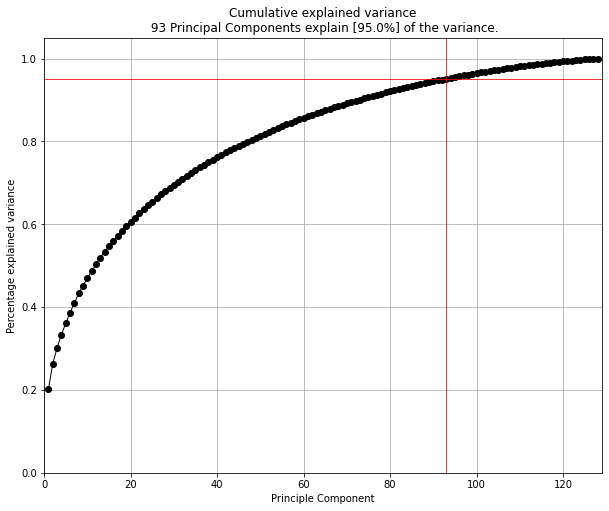

<Figure size 432x288 with 0 Axes>

In [10]:
fig, ax = pca_model.plot()

In [11]:
results['PC']

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93
0,-0.697867,0.311839,-0.246457,0.279815,0.098140,-0.070601,0.199326,-0.140812,-0.210391,0.056473,...,0.010271,-0.007610,0.027124,-0.005263,-0.004501,0.005231,0.033074,-0.023781,0.010388,-0.041253
1,0.455201,0.102195,0.166899,-0.138198,0.411179,-0.190889,0.251168,0.034929,-0.051979,-0.276295,...,0.064085,0.046634,-0.063995,-0.129349,0.055713,0.035724,-0.046026,0.003850,-0.081998,0.081507
2,0.133599,0.240152,-0.239428,-0.052683,0.121791,-0.395205,0.184167,-0.005197,-0.082248,-0.343059,...,-0.004439,0.087038,-0.012133,-0.022520,-0.002229,0.058132,-0.044357,0.037386,-0.041249,-0.010088
3,-0.260444,-0.239955,0.229482,-0.497426,0.060253,-0.100755,0.162974,0.086415,0.043453,0.202363,...,0.014091,-0.022705,0.044732,-0.140180,0.134010,0.021463,0.048153,-0.143830,0.021188,-0.076379
4,0.170875,0.273287,-0.239367,0.102883,0.128076,-0.335625,0.141997,-0.245573,0.151959,-0.189266,...,-0.040632,0.055027,0.014084,-0.078770,0.046498,-0.026784,0.008446,-0.096360,-0.072821,0.057856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,-0.168902,-0.104388,0.172247,-0.358604,-0.272054,0.283466,-0.379529,-0.017412,0.196504,0.188768,...,0.023778,0.073112,-0.023462,0.088505,0.064166,-0.026921,-0.003489,-0.085592,-0.036749,0.044193
11516,-0.074597,0.355890,-0.257149,-0.242689,0.223427,-0.015397,-0.088463,0.308051,-0.322208,-0.312299,...,0.002437,-0.062085,-0.132170,0.088452,-0.052519,0.053425,-0.056214,-0.106584,0.002145,-0.030493
11517,0.254494,0.569552,-0.385305,-0.061182,0.121123,0.018764,-0.105561,0.061769,0.064997,-0.215245,...,0.077705,0.084637,0.030466,-0.064298,-0.033349,-0.116366,0.186544,0.062472,0.022047,-0.066706
11518,-0.170217,0.074070,0.020660,-0.100434,-0.090549,-0.000151,-0.077001,0.199951,0.107403,0.196433,...,0.058295,0.020321,0.008791,0.014333,0.080443,0.026695,0.061069,-0.030056,-0.050869,0.058211


In [12]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=10).fit(results['PC'])
clustering.labels_

array([0, 0, 0, ..., 0, 0, 0])

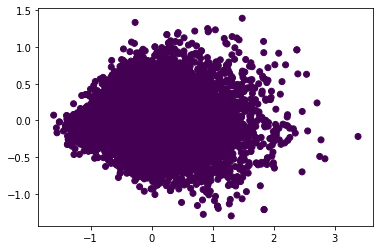

In [13]:
import matplotlib.pyplot as plt

plt.scatter(results['PC'].iloc[:,0], results['PC'].iloc[:,1], c=clustering.labels_)

KeyboardInterrupt: 

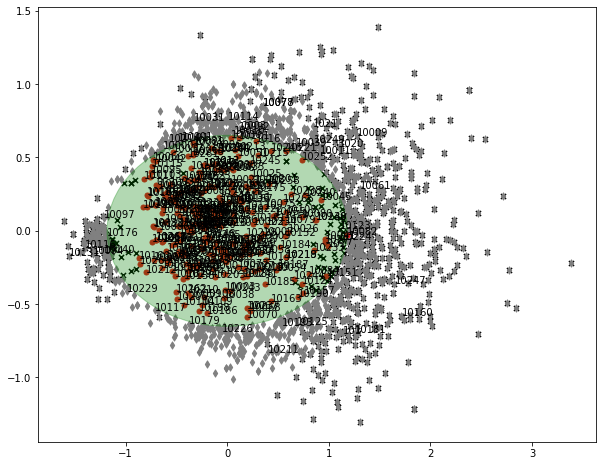

In [14]:
pca_model.biplot(legend=True, SPE=True, hotellingt2=True)

In [19]:
import umap
reducer = umap.UMAP()
umap_embedding = reducer.fit_transform(action_df)

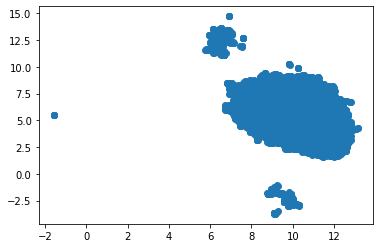

In [20]:
plt.scatter(umap_embedding[:,0], umap_embedding[:,1])

In [21]:
clustering2 = DBSCAN(eps=3, min_samples=2).fit(umap_embedding)

In [22]:
clustering2.labels_

array([0, 0, 0, ..., 0, 0, 0])

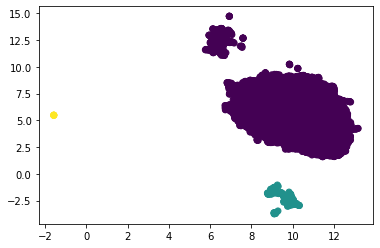

In [23]:
plt.scatter(umap_embedding[:,0], umap_embedding[:,1], c=clustering2.labels_)

In [32]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(umap_embedding)
kmeans.labels_

array([0, 1, 1, ..., 1, 2, 2], dtype=int32)

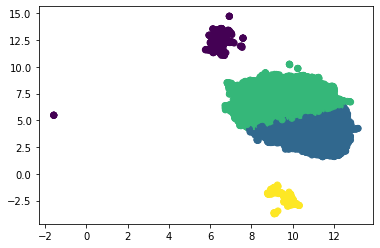

In [33]:
plt.scatter(umap_embedding[:,0], umap_embedding[:,1], c=kmeans.labels_)

In [34]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering().fit(umap_embedding)
clustering.labels_

array([0, 1, 0, ..., 0, 0, 0])

In [35]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, random_state=0).fit(umap_embedding)
gm_label = gm.predict(umap_embedding)

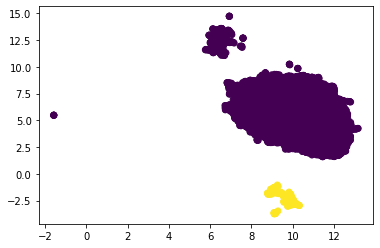

In [36]:
plt.scatter(umap_embedding[:,0], umap_embedding[:,1], c=gm_label)

In [40]:
clus1 = [i for i, e in enumerate(umap_embedding) if (e[0]>6) & (e[1]>0) & (e[1]<11)]
clus2 = [i for i, e in enumerate(umap_embedding) if (e[1]>=11)]
clus3 = [i for i, e in enumerate(umap_embedding) if (e[0]<=5)]
clus4 = [i for i, e in enumerate(umap_embedding) if (e[1]<=1)]
len(clus1) + len(clus2) + len(clus3) + len(clus4)

11520

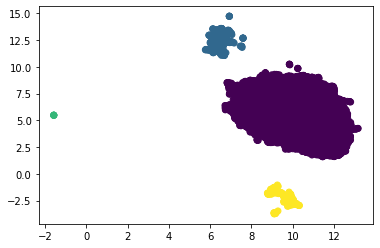

In [41]:
manual_label = pd.concat([pd.DataFrame(zip(*[clus1, [1] * len(clus1)])),
pd.DataFrame(zip(*[clus2, [2] * len(clus2)])),
pd.DataFrame(zip(*[clus3, [3] * len(clus3)])),
pd.DataFrame(zip(*[clus4, [4] * len(clus4)]))], axis=0)
manual_label.columns = ['idx', 'manual_label']
color_manual_label = manual_label.sort_values(['idx'], ascending=True)['manual_label']
plt.scatter(umap_embedding[:,0], umap_embedding[:,1], c=color_manual_label)

In [42]:
df['manual_label'] = color_manual_label.reset_index(drop=True)
df[df['manual_label']==1]

,action,state,manual_label
1,mr carvin understand test articulate reduce an...,entirely mr chief justice reason involve diffe...,1
2,talk concern analysis would drive racial propo...,well mean neutral system must change order max...,1
3,really maximize participation equalize word co...,well example would eliminate valuable antifrau...,1
4,thank mr chief justice mr carvin understand ra...,well justice thomas think speak precisely term...,1
5,causation standard implicit neutrality argument,sense result obviously connote causation right...,1
...,...,...,...
11515,let's put aside unwilling second allege employ...,think would look know publicly disclose financ...,1
11516,allege dispute pleading stage envision kind pr...,well mean think allege sufficient particularit...,1
11517,question subject matter jurisdiction article i...,exactly right honor that's actually happen dis...,1
11518,think that's right separate factual proceeding...,exactly that's actually happen plan overfunded...,1


In [43]:
df[df['manual_label']==2]

,action,state,manual_label
0,hear argument morning case number brnovich ver...,mr chief justice may please court think key co...,2
92,hear argument morning original case florida ge...,thank mr chief justice may please court last t...,2
93,hear argument morning original case florida ge...,mr chief justice may please court appeal counc...,2
94,we'll hear argument next case smith versus ber...,thank mr chief justice may please court last t...,2
95,we'll hear argument next case smith versus ber...,mr chief justice may please court appeal counc...,2
...,...,...,...
11387,mr clement problem justice scalia dissent salv...,well easy justice sotomayor majority actually ...,2
11410,we'll hear argument next case georgia versus p...,mr chief justice may please court eleventh cir...,2
11425,mr johnson georgia official annotated code off...,think benefit reader finding aid present think...,2
11451,we'll hear argument next case ramos versus lou...,mr chief justice may please court last term ti...,2


In [44]:
df[df['manual_label']==3]

,action,state,manual_label
3504,add also include ever doubt also include people,honor candid though also include one subsection,3
3505,add also include ever doubt also include people,honor may answer question reserve remainder ti...,3
3506,add also include ever doubt also include people,difference darpa use can't get enjoin use use ...,3
3507,add also include ever doubt also include people,yes honor several reason first physical-presen...,3
7868,well see dodd-frank expand category people lim...,well expand people situation like self-regulat...,3


In [45]:
df[df['manual_label']==4]

,action,state,manual_label
43,give,know case,4
125,thank thank counsel mr katyal,well first go consider dollar cent also consid...,4
126,thank thank counsel mr katyal,thank mr chief justice may please court friend...,4
147,thank mr chief justice mr primis agree reducti...,compare pre-reservoir pre-army corp operation ...,4
226,thank mr goldstein mr rosenkranz,thank mr chief justice may please court google...,4
...,...,...,...
11390,thank counsel mr kneedler,mr chief justice may please court chief justic...,4
11427,thank counsel mr yang,mr chief justice may please court court bank d...,4
11435,thank counsel mr citron,mr chief justice may please court think useful...,4
11499,thank counsel mr joshi,mr chief justice may please court trustee brea...,4


In [51]:
df1 = df[df['manual_label']==1][['action', 'state']]
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df1['action'].tolist())
X.shape

(10741, 9840)

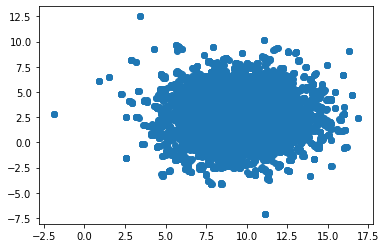

In [63]:
reducer1 = umap.UMAP(n_neighbors=5)
umap_embedding1 = reducer1.fit_transform(X)
plt.scatter(umap_embedding1[:,0], umap_embedding1[:,1])

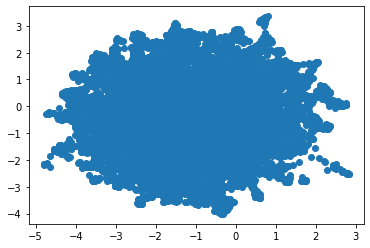

In [64]:
reducer1 = umap.UMAP(n_neighbors=35)
umap_embedding1 = reducer1.fit_transform(X)
plt.scatter(umap_embedding1[:,0], umap_embedding1[:,1])

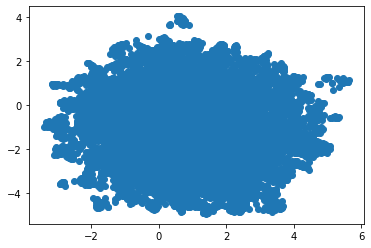

In [65]:
reducer1 = umap.UMAP(n_neighbors=25, min_dist=0.25)
umap_embedding1 = reducer1.fit_transform(X)
plt.scatter(umap_embedding1[:,0], umap_embedding1[:,1])

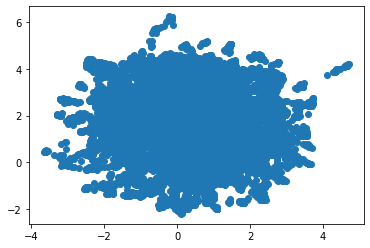

In [66]:
reducer1 = umap.UMAP(n_neighbors=25, min_dist=0.05)
umap_embedding1 = reducer1.fit_transform(X)
plt.scatter(umap_embedding1[:,0], umap_embedding1[:,1])

In [70]:
pd.set_option('display.max_colwidth', None)
df[df['manual_label']==1].head()

,action,state,manual_label
1,mr carvin understand test articulate reduce anything deal time place manner intent test rather result test that's provide section word long time place manner restriction there's difference minority voter white voter problem true,entirely mr chief justice reason involve differential system unequal access regardless whether unequal access racially motivate would prove intent behind differential access provide minority suppress hinder minority vote that's key distinction mobile versus bolden,1
2,talk concern analysis would drive racial proportionality respondent approach understand concern talk districting bad thing talk electoral procedure,well mean neutral system must change order maximize minority voting strength regardless strong justification thing provide unfairness minority must rejigger every aspect time place manner registration election day early voting order maximize minority participation bad kind race-conscious activity subordinate,1
3,really maximize participation equalize word come disparate result disparate result avoid,well example would eliminate valuable antifraud concern implicate ban ballot harvesting would substitute federal court state legislatures make rule question what's wrong question system impose unfairness group nonetheless change simply find different method vote convenient,1
4,thank mr chief justice mr carvin understand race neutrality argument normally see come context non-discrimination statute fourteenth amendment really require equal treatment race neutrality approach fit within language voting right act though speak term,well justice thomas think speak precisely term say voting practice cannot result minority less opportunity non-minorities say system need equally open say long everyone opportunity system equally open section condemn respondent however would say even minority give precisely opportunity unless utilize proportionally somehow come within constraint section there's nothing text section say need expand time place manner restriction enhance proportionality maximization indeed rule virtually every time place manner restriction country would illegal overnight severe disproportionate utilization socioeconomic disparity ubiquitous surely congress intend kind sea change would give hint legislative history rule contrary text section formulation congress intend,1
5,causation standard implicit neutrality argument,sense result obviously connote causation right question prohibited cause prohibited result plain language section tell system can't result provide less opportunity minority say can't result provide opportunity whatever reason utilize extent causation question question state cause say can't cause less opportunity side say can't anything result disproportionate outcome,1


In [ ]:
# TO DO:
# 1. switch the action and state merge during transcript cleaning, so that in each pair, the state happens before
# the action (action is a response to state not the opposite)
# 2. include action variables (justice name, president that appointed the justice, title, starting year, ending year)
# while creating state-action pairs, if either state or action is shorter than 2 seconds (after reading some text)
# it's likely that there's an interruption and we'll combine the two rows into one.

In [72]:
df4 = pd.read_csv('action_state_text_v4.csv', index_col=0)
df4

,start_x,stop_x,start_y,stop_y,speaker_name_x,speaker_name_y,speaker_roles_1_appointing_president_y,speaker_roles_1_role_title_y,speaker_roles_1_date_start_y,speaker_roles_1_date_end_y,agent_state,judge_action,action_duration,agent_duration,judge_action_cleaned,agent_state_cleaned
0,186.705,215.73,215.73,240.995,Michael A. Carvin,"John G. Roberts, Jr.",George W. Bush,Chief Justice of the United States,1.127970e+09,0.0,"Not entirely, Mr. Chief Justice, for this reason: It does involve differential systems, unequal access, but regardless of whether or not that unequal access is racially motivated, you would not have to prove that the intent behind the differential access provided to minorities was to suppress or hinder the minority vote. And that's a key distinction from Mobile versus Bolden.","Now you -- you talk about the concern being that the analysis would be driven to racial proportionality under the Respondents' approach. Now I understand the concerns about that when you're talking about districting, but why is that -- why is that a bad thing when you're talking about electoral procedures?",29.025,25.265,"['talk', 'concern', 'analysis', 'would', 'drive', 'racial', 'proportionality', 'respondent', 'approach', 'understand', 'concern', 'talk', 'districting', 'bad', 'thing', 'talk', 'electoral', 'procedure']","['entirely', 'mr', 'chief', 'justice', 'reason', 'involve', 'differential', 'system', 'unequal', 'access', 'regardless', 'whether', 'unequal', 'access', 'racially', 'motivate', 'would', 'prove', 'intent', 'behind', 'differential', 'access', 'provide', 'minority', 'suppress', 'hinder', 'minority', 'vote', ""that's"", 'key', 'distinction', 'mobile', 'versus', 'bolden']"
1,357.335,438.79,438.79,445.930,Michael A. Carvin,Clarence Thomas,George H. W. Bush,Associate Justice of the Supreme Court of the United States,6.881940e+08,0.0,"Well, Justice Thomas, I think it speaks precisely in those terms. It says that a voting practice cannot result in minorities having less opportunity than non-minorities. It says the system needs to be equally open. So what it's saying is as long as everyone has the same opportunity and the system is equally open, Section 2 does not condemn it. The Respondents, however, would say that even if minorities are given precisely the same opportunity, unless they utilize it proportionally, then somehow that comes within the constraints of Section 2. But, again, there's nothing in the text of Section 2 which says you need to expand time, place, and manner restrictions to enhance proportionality or maximization. Indeed, if that had been the rule, in 1982, virtually every time, place, and manner restriction in the country would have been illegal overnight because there was severe disproportionate utilization and socioeconomic disparities were ubiquitous. And surely, if Congress had intended that kind of sea change, it would have given some hint of it in the legislative history. So this rule is both contrary to the text of Section 2 and any other formulation of what Congress was intending.",So is there a causation standard implicit in your neutrality argument?,81.455,7.140,"['causation', 'standard', 'implicit', 'neutrality', 'argument']","['well', 'justice', 'thomas', 'think', 'speak', 'precisely', 'term', 'say', 'voting', 'practice', 'cannot', 'result', 'minority', 'less', 'opportunity', 'non-minorities', 'say', 'system', 'need', 'equally', 'open', 'say', 'long', 'everyone', 'opportunity', 'system', 'equally', 'open', 'section', 'condemn', 'respondent', 'however', 'would', 'say', 'even', 'minority', 'give', 'precisely', 'opportunity', 'unless', 'utilize', 'proportionally', 'somehow', 'come', 'within', 'constraint', 'section', ""there's"", 'nothing', 'text', 'section', 'say', 'need', 'expand', 'time', 'place', 'manner', 'restriction', 'enhance', 'proportionality', 'maximization', 'indeed', 'rule', 'virtually', 'every', 'time', 'place', 'manner', 'restriction', 'country', 'would', 'illegal', 'overnight', 'seve

In [73]:
action_list = embed(df4['judge_action_cleaned'].tolist())
action_df4 = pd.DataFrame(action_list.numpy())
action_df4.columns = ['embed_' + str(e) for e in range(action_df4.shape[1])]
action_df4

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_118,embed_119,embed_120,embed_121,embed_122,embed_123,embed_124,embed_125,embed_126,embed_127
0,-0.558032,-0.128873,-0.133144,0.043226,0.017131,-0.195955,-0.232650,0.070666,-0.042911,0.014886,...,-0.087685,-0.167823,0.337814,0.196095,-0.019861,0.021689,0.097249,0.408312,-0.145107,-0.151005
1,-0.352233,0.026613,-0.134861,0.033117,-0.110066,0.053125,-0.151325,-0.016929,0.104874,-0.084269,...,0.024580,-0.068231,0.093914,0.195484,0.050297,0.074062,0.044033,0.187169,-0.173433,-0.081511
2,-0.809172,-0.015465,-0.236170,0.081357,-0.000370,-0.053449,-0.286029,-0.008561,-0.016222,0.023467,...,0.107819,-0.276175,0.060389,0.000789,-0.043028,-0.260568,0.187331,0.314392,-0.123593,-0.075665
3,-0.506669,0.001496,-0.120030,-0.085427,0.017692,-0.025749,-0.254523,0.007150,0.220395,-0.032401,...,0.070910,-0.072913,0.025063,0.063025,-0.125343,-0.198359,0.186409,0.137360,-0.053643,0.025948
4,-0.506669,0.001496,-0.120030,-0.085427,0.017692,-0.025749,-0.254523,0.007150,0.220395,-0.032401,...,0.070910,-0.072913,0.025063,0.063025,-0.125343,-0.198359,0.186409,0.137360,-0.053643,0.025948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13943,-0.434045,0.025139,0.036087,0.095606,0.051346,-0.093239,-0.039444,0.029634,0.124186,0.082309,...,0.067876,0.117735,0.110439,0.167893,-0.009983,-0.050423,-0.035804,0.109940,-0.216390,-0.158000
13944,-0.532201,-0.049836,-0.060096,0.041875,0.004141,-0.051134,-0.301308,0.136019,0.011987,-0.104473,...,-0.071207,-0.010408,0.138124,0.157157,0.052198,-0.180891,0.067839,0.180294,-0.154086,-0.041103
13945,-0.677967,-0.269890,-0.135721,0.179464,-0.100418,-0.148004,-0.179123,-0.025147,0.053964,0.037324,...,-0.131357,-0.218970,0.123320,0.105072,0.175432,-0.062577,0.207576,0.377651,-0.179285,-0.034478
13946,-0.453874,-0.154392,-0.044981,-0.073065,0.050142,-0.108555,-0.194051,0.154984,0.062892,0.117256,...,-0.015006,0.007255,0.201197,0.053678,0.114732,-0.114634,-0.000638,0.375327,-0.094321,0.266846


In [93]:
import umap
reducer = umap.UMAP(n_neighbors=5, min_dist=0.25, random_state=1)
umap_embedding = reducer.fit_transform(action_df4)

/Users/zhiyulin/opt/anaconda3/envs/anly580/lib/python3.8/site-packages/umap/spectral.py:252: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


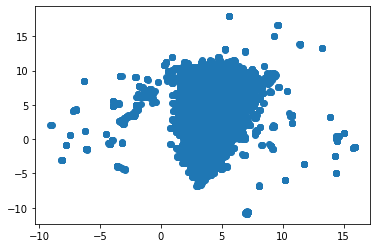

In [94]:
plt.scatter(umap_embedding[:,0], umap_embedding[:,1])

In [95]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df4['judge_action_cleaned'].tolist())
X.shape

(13948, 9442)

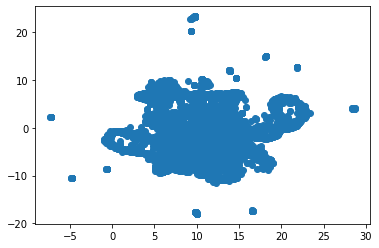

In [98]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0.25, random_state=1)
umap_embedding = reducer.fit_transform(X)
plt.scatter(umap_embedding[:,0], umap_embedding[:,1])

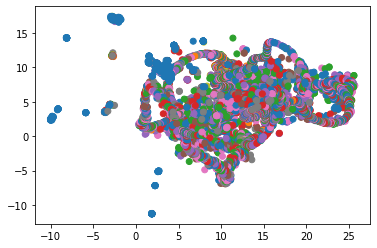

In [105]:
import seaborn as sns
reducer = umap.UMAP(n_neighbors=15, min_dist=0.25, random_state=1)
umap_embedding = reducer.fit_transform(X)
plt.scatter(umap_embedding[:,0], umap_embedding[:,1],
           c=[sns.color_palette()[int(x)] for x in df4.speaker_name_y.map(
               dict(zip(*[df4.speaker_name_y.unique().tolist(), list(range(9))]))).fillna(0)])


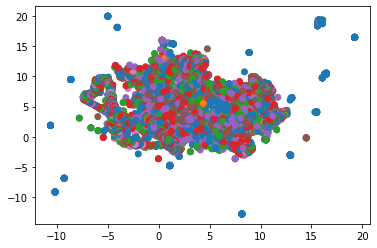

In [109]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=1)
umap_embedding = reducer.fit_transform(X)
plt.scatter(umap_embedding[:,0], umap_embedding[:,1],
           c=[sns.color_palette()[int(x)] for x in df4.speaker_roles_1_appointing_president_y.map(
               dict(zip(*[df4.speaker_roles_1_appointing_president_y.unique().tolist(), list(range(7))]))).fillna(0)])


In [110]:
df4.iloc[-8:,:]

,start_x,stop_x,start_y,stop_y,speaker_name_x,speaker_name_y,speaker_roles_1_appointing_president_y,speaker_roles_1_role_title_y,speaker_roles_1_date_start_y,speaker_roles_1_date_end_y,agent_state,judge_action,action_duration,agent_duration,judge_action_cleaned,agent_state_cleaned
13940,2918.12,2937.12,2937.12,2975.72,Joseph R. Palmore,Elena Kagan,Barack Obama,Associate Justice of the Supreme Court of the United States,1.281157e+09,0.0,"Sure. First of all, under Rings v. Bird, the simple conferral of a cause of a cause of action is not enough to confer standing. And then what you were alluding to in 502(a)(2) and (a)(3), is simply a bare cause of action. That's not enough. There has to be an invasion of statutorily protected right and there has to be a concrete injury.","At the very least, though, Mr. Palmore, that suggests who Congress thought the fiduciary obligations ran to. In other words, this -- this goes back to this question of: Who really owns this thing equitably? Is it the plan or is it the beneficiaries and participants? And in creating those causes of action, Congress essentially, you know, indicated that it thought that the obligations ran to the beneficiaries and the participants, meaning that it's the beneficiaries and the participants who have the equitable ownership stake in the financial integrity of the fund.",19.00,38.60,"['least', 'though', 'mr', 'palmore', 'suggest', 'congress', 'think', 'fiduciary', 'obligation', 'run', 'word', 'go', 'back', 'question', 'really', 'own', 'thing', 'equitably', 'plan', 'beneficiary', 'participant', 'create', 'cause', 'action', 'congress', 'essentially', 'know', 'indicate', 'think', 'obligation', 'run', 'beneficiary', 'participant', 'mean', 'beneficiary', 'participant', 'equitable', 'ownership', 'stake', 'financial', 'integrity', 'fund']","['sure', 'first', 'ring', 'v', 'bird', 'simple', 'conferral', 'cause', 'cause', 'action', 'enough', 'confer', 'standing', 'allude', 'simply', 'bare', 'cause', 'action', ""that's"", 'enough', 'invasion', 'statutorily', 'protect', 'right', 'concrete', 'injury']"
13941,3010.48,3032.80,3032.80,3043.36,Joseph R. Palmore,Elena Kagan,Barack Obama,Associate Justice of the Supreme Court of the United States,1.281157e+09,0.0,"Your Honor, what this Court said -- has -- has said in subsequent cases after Russell was that there are -- there are other kinds of fiduciary duties which may run directly to a beneficiary, so, for instance, the right to receive truthful information, but the Court reiterated in verity that the -- that the fiduciary duty with respect to plan asset management runs to the trust. But even if you don't --","I mean, isn't that a fairly odd thing to say the that fiduciary obligations runs to an abstract plan rather than the beneficiaries and the participants who are supposed to benefit from it?",22.32,10.56,"['mean', 'fairly', 'odd', 'thing', 'say', 'fiduciary', 'obligation', 'run', 'abstract', 'plan', 'rather', 'beneficiary', 'participant', 'suppose', 'benefit']","['honor', 'court', 'say', 'say', 'subsequent', 'case', 'russell', 'kind', 'fiduciary', 'duty', 'may', 'run', 'directly', 'beneficiary', 'instance', 'right', 'receive', 'truthful', 'information', 'court', 'reiterate', 'verity', 'fiduciary', 'duty', 'respect', 'plan', 'asset', 'management', 'run', 'trust', 'even']"
13942,3043.36,3112.20,3112.20,3124.92,Joseph R. Palmore,Stephen G. Breyer,Bill Clinton,Associate Justice of the Supreme Court of the United States,7.758900e+08,0.0,"No, Your Honor, because ERISA was an innovation in that it created the plan as an actual legal entity with -- and a heavily regulated one, at trust -- at common law, the trust itself wasn't the legal entity. It was just a series of relationships between individuals. So -- so ERISA was an innovation. But even if you don't agree with me on that, this question would still remain, even if the fiduciary duties flow to the individuals, can they sue if they are not harmed? So at the contingent beneficiary an

In [ ]:
# better text processing & tagging
# map structure sandeep to the convo (linguistic cues for mining, feature engineering)
# state is not just what the attorney said. Redefine state (sandeep's framework). So first map attorney's stuff to 
# state (30~40 categories), then use GPT2/seq2seq to map state

